### Are we still Dreary? 
Andrew Gettelman May 2025
Digital Earths km-scale Global Hackathon


Are models still 'Dreary'? 

In [17]:
import healpix as hp
import numpy as np
import xarray as xr
import intake
import numcodecs
import zarr

import easygems.healpix as egh
import easygems.remap as egr

import matplotlib.pyplot as plt

import dask.array as da

import glob
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

In [18]:
plt.rcParams['figure.figsize'] = [12, 8]

In [19]:
current_location = "NERSC"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

In [20]:
list(cat)

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'nicam_gl11',
 'scream-dkrz',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'scream_ne120_inst',
 'tracking',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3',
 'wrf_conus',
 'wrf_samerica']

In [21]:
import pandas as pd

pd.DataFrame(cat["scream2D_hrly"].describe()["user_parameters"])


name                     description type  \
0  zoom  zoom resolution of the dataset  int   

                              allowed  default  
0  [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]        2

In [22]:
ds7 = cat["scream2D_hrly"](zoom=7).to_dask() 
ds7

<xarray.Dataset> Size: 15GB
Dimensions:   (crs: 0, time: 9457, cell: 196608)
Coordinates:
  * crs       (crs) float64 0B 
  * time      (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
Dimensions without coordinates: cell
Data variables:
    pr        (time, cell) float32 7GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    rlut      (time, cell) float32 7GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    ELEV      (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
    LANDFRAC  (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
    lat       (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
    lon       (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

<Figure size 1200x800 with 0 Axes>

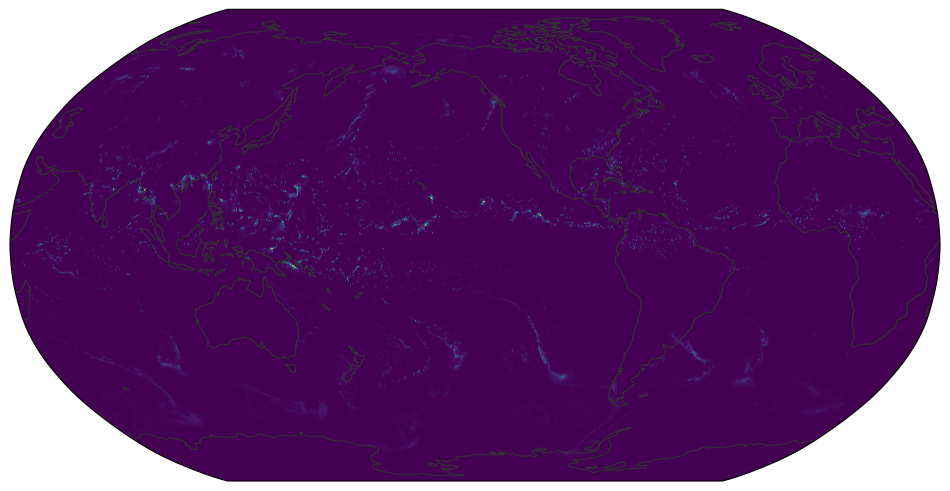

In [23]:
egh.healpix_show(ds7["pr"].isel(time=20));

In [37]:
# Diurnal cycle by season....

ds7 = ds7.assign_coords(
    hour=ds7.time.dt.hour,
    season=ds7.time.dt.season
)

# Group by season and hour, then average over time
# This gives the mean diurnal cycle for each season and location
diurnal = ds7['pr'].groupby("season").apply(
    lambda x: x.groupby("hour").mean("time")
)

# Optional: reorder seasons if needed (DJF, MAM, JJA, SON)
season_order = ["DJF", "MAM", "JJA", "SON"]
diurnal = diurnal.sel(season=season_order)

In [54]:
scl=86400.*1000. #mm/day

<Figure size 1200x800 with 0 Axes>

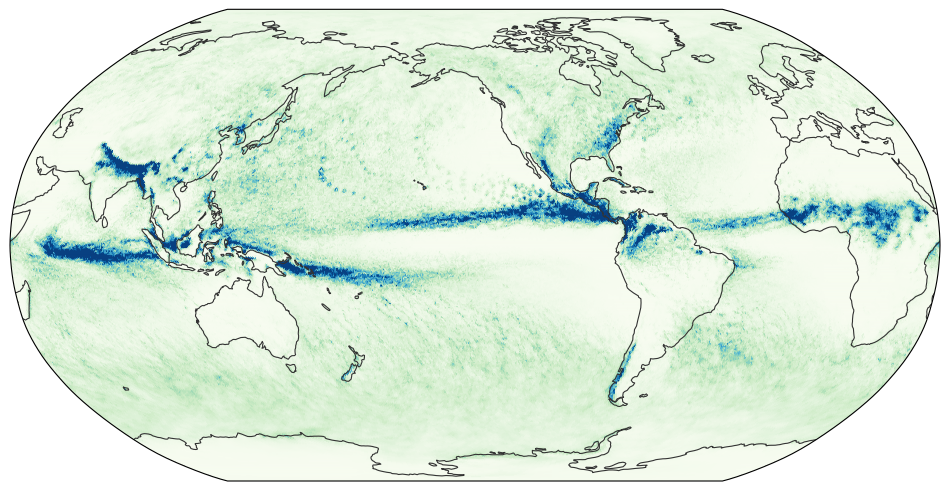

In [51]:
egh.healpix_show(diurnal.sel(season='JJA',hour=0)*scl,cmap='GnBu',vmax=20.)

<Figure size 1200x800 with 0 Axes>

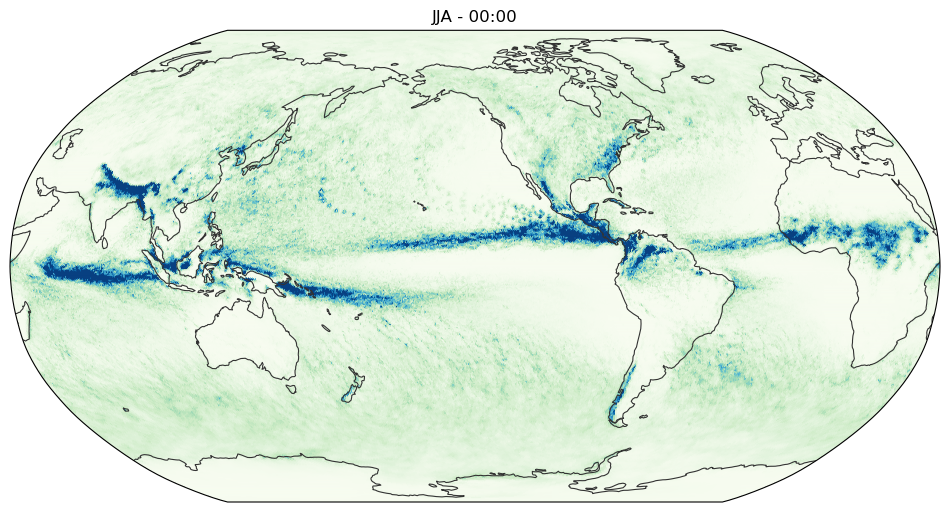

<Figure size 1200x800 with 0 Axes>

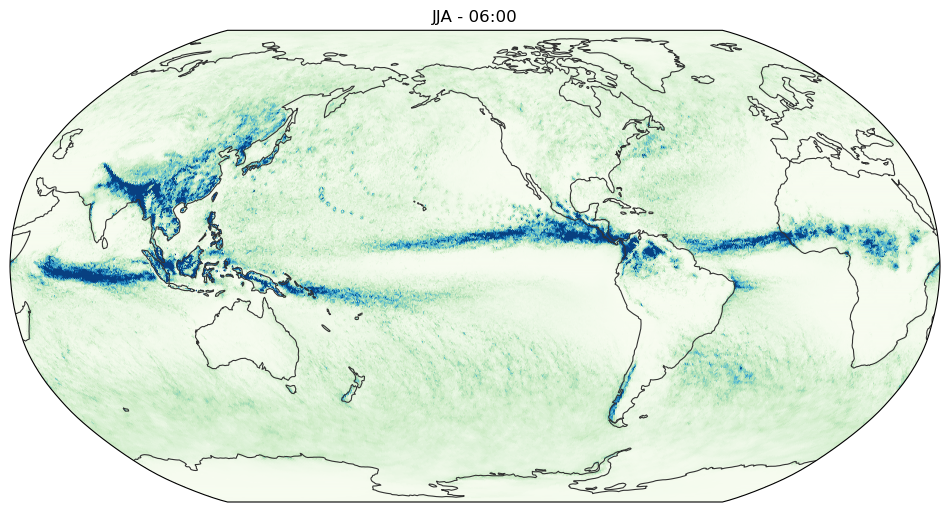

<Figure size 1200x800 with 0 Axes>

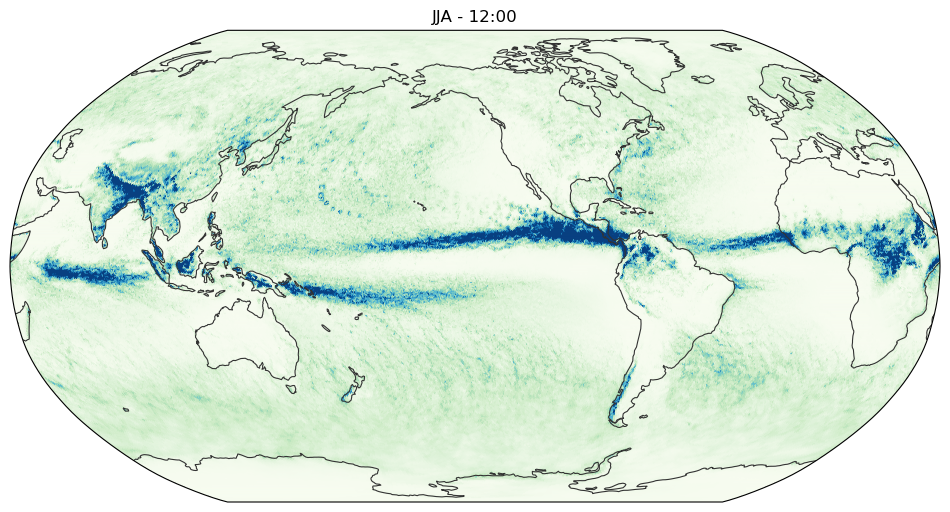

<Figure size 1200x800 with 0 Axes>

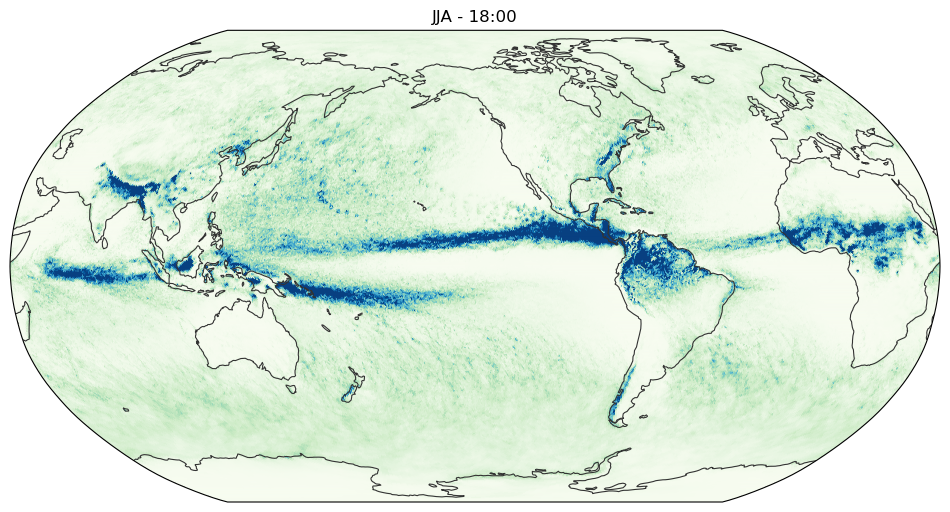

In [59]:
import matplotlib.pyplot as plt

# Define hours to plot
hours = [0, 6, 12, 18]

fig = plt.figure(figsize=(12, 8))

#for season in ['DJF', 'MAM', 'JJA', 'SON']:

season='JJA'
for hour in [0, 6, 12, 18]:
    data = diurnal.sel(season=season, hour=hour)*scl
    egh.healpix_show(data, cmap='GnBu', vmax=20.)
    plt.title(f"{season} - {hour:02d}:00")
    plt.show()

### CERES DATA

In [24]:
# temp cat for ceres data
ds_ebaf=cat["CERES_EBAF"](zoom=6).to_dask() 
ds_ebaf

<xarray.Dataset> Size: 649MB
Dimensions:                      (time: 300, cell: 49152, crs: 0)
Coordinates:
  * crs                          (crs) float64 0B 
  * time                         (time) datetime64[ns] 2kB 2000-03-15 ... 202...
Dimensions without coordinates: cell
Data variables:
    cldarea_total_daynight_mon   (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    cldpress_total_daynight_mon  (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    cldtau_total_day_mon         (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    cldtemp_total_daynight_mon   (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    solar_mon                    (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    toa_lw_all_mon               (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    toa_lw_clr_c_mon             (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    toa_net_all_mon              (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    toa_net_clr_c_mon            (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    toa_sw_all_mon               (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
    toa_sw_clr_c_mon             (time, cell) float32 59MB dask.array<chunksize=(24, 49152), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF-TOA_L3B004.2.1
    comment:      Climatology from 07/2005 to 06/2015
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    version:      Edition 4.2.1; Release Date November 25, 2024

<Figure size 1200x800 with 0 Axes>

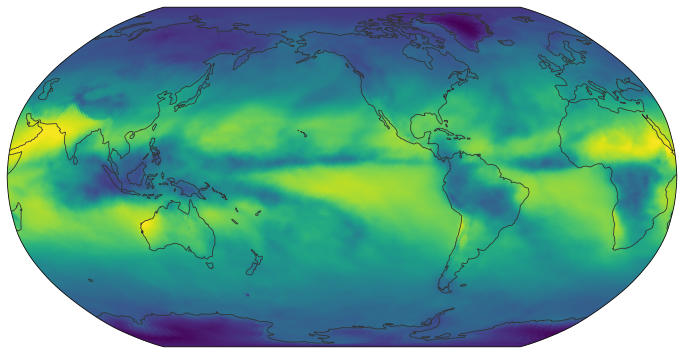

In [25]:
cvar="toa_lw_all_mon"
egh.healpix_show(ds_ebaf[cvar].isel(time=20),dpi=72);

In [29]:
#Monthly climatology...

ebaf_mo = ds_ebaf.groupby("time.month").mean()
ebaf_mo

<xarray.Dataset> Size: 26MB
Dimensions:                      (month: 12, cell: 49152, crs: 0)
Coordinates:
  * crs                          (crs) float64 0B 
  * month                        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: cell
Data variables:
    cldarea_total_daynight_mon   (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    cldpress_total_daynight_mon  (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    cldtau_total_day_mon         (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    cldtemp_total_daynight_mon   (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    solar_mon                    (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    toa_lw_all_mon               (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    toa_lw_clr_c_mon             (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    toa_net_all_mon              (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    toa_net_clr_c_mon            (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    toa_sw_all_mon               (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
    toa_sw_clr_c_mon             (month, cell) float32 2MB dask.array<chunksize=(12, 49152), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF-TOA_L3B004.2.1
    comment:      Climatology from 07/2005 to 06/2015
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    version:      Edition 4.2.1; Release Date November 25, 2024

### Precipitation Frequency
Start with a month... pull out the data and make a mask by a threshold? 

Or save a precip mask 

In [61]:
threshold = 1  # example:  1 mm/dy

# Step 1: Create binary mask (1 if pr > threshold, else 0)
mask = (ds7['pr']*scl > threshold)

# Step 2: Group by month and count
count = mask.groupby("time.month").sum("time")  # Number of hours above threshold

# Optional: frequency (fraction of time exceeding threshold)
frequency = mask.groupby("time.month").mean("time")  # Fraction of time above threshold

<Figure size 1200x800 with 0 Axes>

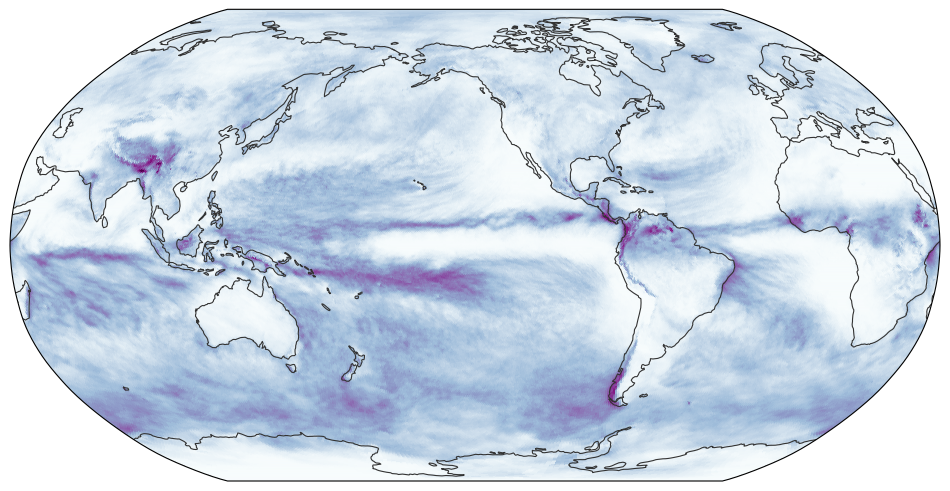

In [66]:
egh.healpix_show(frequency.sel(month=6),cmap="BuPu")

In [ ]:
## Add amplitude of the diurnal cycle....